# Main Notebook for Wireless Networks and Communication Project

## Intrusion Detection System Using Artificial Intelligence: CIC IDS Dataset

This project aims to build an intelligent system for detecting and preventing network attacks and threats using artificial intelligence and machine learning. By analyzing detailed traffic logs and packet metadata, the system can identify patterns of malicious behavior such as port scanning, unusual packet flows, or suspicious connection states. The core idea is to leverage predictive models that learn from historical traffic data to proactively detect anomalies and potential intrusions. This approach not only supports in-depth traffic analysis but also enables real-time threat prevention, contributing to stronger and smarter network security infrastructures.  
This notebook will showcase the dataset and the steps followed to create the model for prediction.

# 0. Libraries and Needed Tools

Let us import some needed `Python` libraries

In [1]:
!pip install pyarrow
!pip install scikit-learn
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1. Dataset

### 1.1. Data Description

For this study, we will be using an academic intrusion detection dataset originally published by the Canadian Institute for Cybersecurity. All credit for the dataset goes to Dr. Iman Sharafaldin, Dr. Arash Habibi Lashkari, and Dr. Ali Ghorbani.  
The dataset contains rich connection-level metadata for network traffic, including various protocol statistics and labeled indicators of malicious activity. It is structured to support the development and evaluation of intrusion detection and traffic classification models.  
The data used for this study is accessible via the following link: [Kaggle](https://www.kaggle.com/datasets/dhoogla/cicids2017/)

In [3]:
# directory of data files
data_directory = "data"

# get all .parquet file paths
data_files = glob.glob(os.path.join(data_directory, "*.parquet"))

# read and concatenate them into one DataFrame
data = pd.concat([pd.read_parquet(file) for file in data_files], ignore_index=True)

# preview the result
data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,640,7,4,440,358,220,0,62.857143,107.349007,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,900,9,4,600,2944,300,0,66.666664,132.287567,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,1205,7,4,2776,2830,1388,0,396.571442,677.274658,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,511,7,4,452,370,226,0,64.571426,110.276711,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,773,9,4,612,2944,306,0,68.000000,134.933319,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


### 1.2. Exploratory Data Analysis

In [4]:
print(f"Total rows: {len(data)}")
print(f"Total columns: {len(data.columns)}")

Total rows: 2313810
Total columns: 78


In [5]:
data.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,...,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2.313810e+06,2313810.0,2.313810e+06,2.313810e+06,2.313810e+06
mean,1.050673e+01,1.807575e+07,1.108391e+01,1.255334e+01,6.664045e+02,1.976976e+04,2.506291e+02,2.142396e+01,6.880509e+01,8.299154e+01,...,6.537630e+00,-3.360480e+03,9.977086e+04,5.032396e+04,1.874053e+05,7.131980e+04,10172611.0,6.164089e+05,1.063716e+07,9.688133e+06
std,5.416040e+00,3.640823e+07,8.291879e+02,1.103179e+03,1.105009e+04,2.503141e+06,7.855073e+02,6.334192e+01,2.023045e+02,3.078814e+02,...,7.039324e+02,1.200084e+06,7.161351e+05,4.345795e+05,1.131814e+06,6.375820e+05,25771430.0,5.084448e+06,2.656441e+07,2.550670e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,4.760000e+02,2.000000e+00,1.000000e+00,3.700000e+01,2.600000e+01,2.000000e+01,0.000000e+00,8.666667e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,6.478300e+04,2.000000e+00,2.000000e+00,7.400000e+01,1.830000e+02,4.300000e+01,6.000000e+00,3.955556e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+01,5.856948e+06,6.000000e+00,5.000000e+00,3.560000e+02,2.306000e+03,2.740000e+02,3.900000e+01,5.400000e+01,8.499406e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
max,1.700000e+01,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,120000000.0,7.690000e+07,1.200000e+08,1.200000e+08


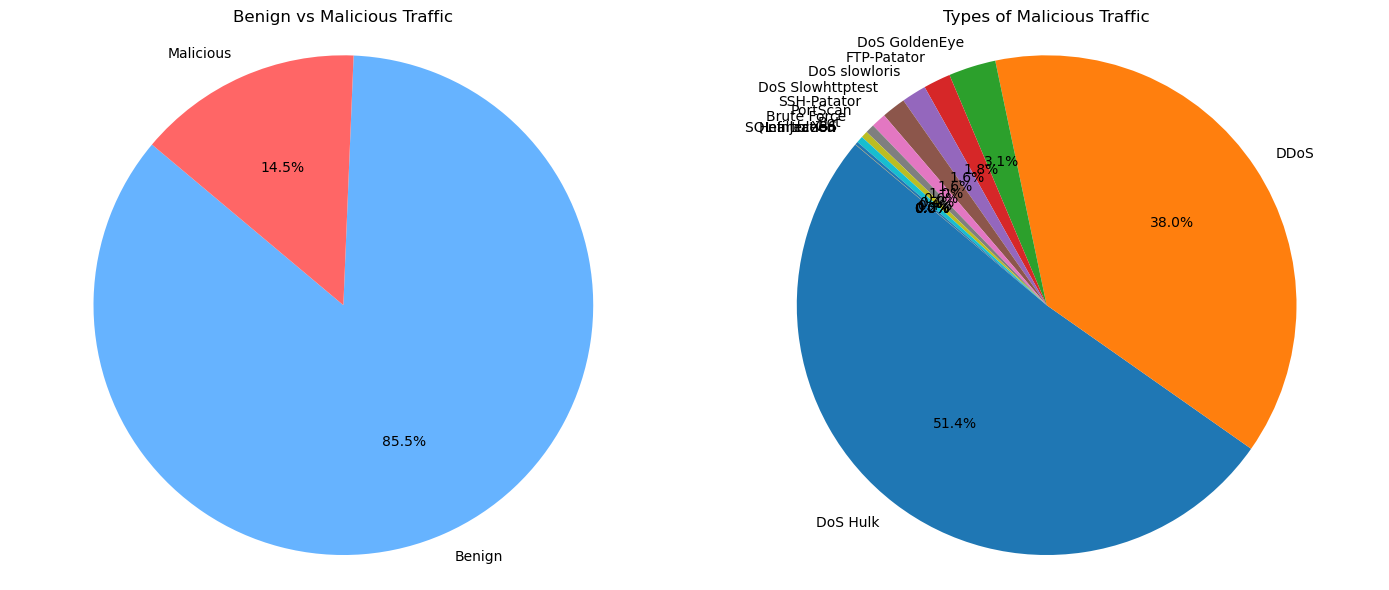

In [6]:
# Fix malformed label names
data['Label'] = data['Label'].replace({
    r'Web Attack\s*[�-]?\s*Brute Force': 'Brute Force',
    r'Web Attack\s*[�-]?\s*XSS': 'XSS',
    r'Web Attack\s*[�-]?\s*Sql Injection': 'SQL Injection'
}, regex=True)

# classify labels
data['label_type'] = data['Label'].apply(lambda x: 'Benign' if 'benign' in x.lower() else 'Malicious')

# count for Benign vs Malicious
label_type_counts = data['label_type'].value_counts()

# count for different malicious labels
malicious_df = data[data['label_type'] == 'Malicious']
malicious_label_counts = malicious_df['Label'].value_counts()

# plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# pie chart: Benign vs Malicious
axs[0].pie(label_type_counts, labels=label_type_counts.index, autopct='%1.1f%%',
           startangle=140, colors=['#66b3ff', '#ff6666'])
axs[0].set_title('Benign vs Malicious Traffic')
axs[0].axis('equal')

# pie chart: Malicious Breakdown
axs[1].pie(malicious_label_counts, labels=malicious_label_counts.index, autopct='%1.1f%%',
           startangle=140)
axs[1].set_title('Types of Malicious Traffic')
axs[1].axis('equal')

plt.tight_layout()
plt.show()

# cleanup
data.drop(columns=['label_type'], inplace=True)


This dataset exhibits a significant class imbalance:

- Class $0$ (Benign) accounts for 85.5% of the data.
- Class $1$ (Malicious) makes up only 14.5%.

As a result, a naive model that always predicts the majority class (Class 0) would already achieve an accuracy of 85.5%.

To be considered effective, any machine learning or deep learning model applied to this dataset must outperform this baseline by accurately detecting instances of the minority class (Class 1). Successfully identifying these malicious samples is crucial to demonstrating the model’s real predictive capability.

### 1.3. Preprocessing

#### Null values and duplicated rows

In [7]:
print(f"Number of missing values: {data.isnull().sum().sum()}")

Number of missing values: 0


In [8]:
print(f"Number of duplicated rows: {data.duplicated().sum()}")

Number of duplicated rows: 82004


In [9]:
data = data.drop_duplicates()
print(f"Total rows: {len(data)}")
print(f"Total columns: {len(data.columns)}")

Total rows: 2231806
Total columns: 78


In [10]:
data = data.rename(columns={'Label': 'Threat'})

In [11]:
# map 'Benign' to 0 and everything else to 1
data['Label'] = data['Threat'].map(lambda x: 0 if x == 'Benign' else 1)
data['Label'] = data['Label'].astype(dtype=np.int32)
print(data['Label'].value_counts())

Label
0    1895314
1     336492
Name: count, dtype: int64


### 1.4 Train-Test Split

When building a deep learning model, we split the dataset into three parts: training, validation, and test sets. The training set is used to teach the model, the validation set helps fine-tune it and monitor for overfitting, and the test set is used at the end to evaluate how well the model performs on completely unseen data.

Since this dataset is imbalanced (most samples are from Class 0), we use stratified splitting to make sure that the class proportions (Class 0 and Class 1) are preserved across all splits. This ensures that each subset represents the overall distribution of the data.

Here, we split 80% of the data for training, and the remaining 20% is evenly divided between validation (10%) and testing (10%).

In [12]:
from sklearn.model_selection import train_test_split

# features
X = data.drop(columns=['Label', 'Threat'])

# targets
y_label = data['Label']
y_threat = data['Threat']

# split features and both targets into train and temp (val + test)
X_train, X_temp, y_label_train, y_label_temp, y_threat_train, y_threat_temp = train_test_split(
    X, y_label, y_threat, test_size=0.2, random_state=42, stratify=y_label
)

# split temp into val and test
X_val, X_test, y_label_val, y_label_test, y_threat_val, y_threat_test = train_test_split(
    X_temp, y_label_temp, y_threat_temp, test_size=0.5, random_state=42, stratify=y_label_temp
)

# check sizes
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 1785444 samples
Validation Set: 223181 samples
Test Set: 223181 samples


### 1.5 Scaling

When working with real-world data like the CIC-IDS-2017 dataset, it's common to encounter outliers—especially in network traffic where attacks can cause unusual spikes in certain features. To handle this, we apply the Robust Scaler, which is designed to reduce the effect of these outliers during preprocessing.

Instead of using the mean and standard deviation (like StandardScaler), the Robust Scaler uses the median and the interquartile range (IQR) to scale the data. This makes it more reliable when the data includes anomalies.

The formula:
$$
X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)}
$$

In [13]:
from sklearn.preprocessing import RobustScaler

def robust_scale_data(X_train, X_val, X_test):
    scaler = RobustScaler()
    # fit on train, transform all
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    # return
    return X_train_scaled, X_val_scaled, X_test_scaled

# apply scaling
X_train_scaled, X_val_scaled, X_test_scaled = robust_scale_data(X_train, X_val, X_test)

# bundle features and both labels into one list for easy access
scaled_data = [
    X_train_scaled, X_val_scaled, X_test_scaled,
    y_label_train, y_label_val, y_label_test,
    y_threat_train, y_threat_val, y_threat_test
]

# check
print(f"Scaled shapes:\nTrain: {X_train_scaled.shape},\nValidation: {X_val_scaled.shape},\nTest: {X_test_scaled.shape}")

Scaled shapes:
Train: (1785444, 77),
Validation: (223181, 77),
Test: (223181, 77)


# 2. Modelling

### 2.1 Approach: Hierarchical Approach for Network Intrusion Detection

For the CIC-IDS dataset, we implemented a hierarchical classification model to address the challenges of imbalanced data and multi-class threat classification. Network intrusion detection systems typically face two significant challenges:
- Class Imbalance: Benign network traffic vastly outnumbers malicious traffic.
- Diverse Attack Types: Malicious traffic includes multiple categories of attacks, each with different patterns and characteristics.

Our hierarchical approach breaks down the classification task into two phases:
- Phase 1: Binary classification to distinguish benign from malicious traffic.  
- Phase 2: Multi-class classification to identify specific attack types among samples classified as malicious.

### 2.2 Architecture

Here is the architecture of the solution:  

![Architecture](assets/IDS-ML.png)

### 2.3 Model Selection

#### **2.3.1 Base Model: XGBOOST3.0**
XGBoost (Extreme Gradient Boosting) serves as our primary model for binary classification in our hierarchical approach. This algorithm excels at processing structured data like network traffic features, making it ideal for distinguishing between benign and malicious network activity.  

XGBoost builds upon the gradient boosting framework by sequentially constructing decision trees that learn from previous errors. The model evolves according to:
$$
F_m(x) = F_{m-1}(x) + η·h_m(x)
$$
Where each new tree $h_m$ contributes to improving the previous model iteration (F_{m-1}), regulated by a learning rate (η). This iterative correction process creates a robust ensemble that balances bias and variance effectively.  

XGBoost offers several critical benefits for network security applications which make it particularly well-suited for the first phase of our hierarchical model:

- **Efficient handling of imbalanced data:** Network traffic typically contains far more benign than malicious samples. XGBoost allows weight adjustment for minority classes, improving detection accuracy.
- **Feature importance insights:** The algorithm automatically identifies which network attributes most significantly contribute to detecting malicious activity, enhancing interpretability.
- **Resource efficiency:** Unlike deep learning approaches that demand extensive computational resources, XGBoost performs effectively on standard hardware.
- **Advanced regularization:** Both L1 and L2 regularization prevent overfitting, ensuring the model generalizes well to new attack patterns.
- **Parallel processing capabilities:** Multi-threaded execution enables rapid training and inference on large network traffic datasets.
- **Superior handling of tabular data:** XGBoost excels with structured network flow features without requiring extensive feature engineering.


#### **2.3.2 Threats Model: Random Forest for Multi-class Classification**
Random Forest was chosen for the second phase due to its effectiveness in multi-class problems:

- **Natural Multi-class Capability:** It naturally handles multi-class problems through voting across ensemble trees.
- **Feature Space Randomization:** It uses bootstrapping and feature bagging to capture diverse patterns among different attack types.
- **Robustness to Overfitting:** The ensemble approach reduces variance and improves generalization across diverse attack patterns.


### 2.4 Performance Evaluation

The hierarchical model is evaluated in two distinct phases:
#### **2.4.1 Phase 1 Metrics (Binary Classification)**

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$  
$$\text{Precision} = \frac{TP}{TP + FP}$$  
$$\text{Recall} = \frac{TP}{TP + FN}$$  
$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$  

#### **2.4.2 Phase 2 Metrics (Multi-class Classification)**

$$\text{Macro-averaged Precision} = \frac{1}{K}\sum_{k=1}^{K}\text{Precision}_k$$
$$\text{Macro-averaged Recall} = \frac{1}{K}\sum_{k=1}^{K}\text{Recall}_k$$
$$\text{Macro-averaged F1-Score} = \frac{1}{K}\sum_{k=1}^{K}\text{F1-Score}_k.$$

Where $K$ is the number of different attack types.

### 2.5 Implementation

Here is the $Python$ implementation of our approach:

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# Define the custom transformer for the hierarchical classification
class HierarchicalClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_model=None, threat_model=None):
        self.base_model = base_model if base_model is not None else XGBClassifier(random_state=42)
        self.threat_model = threat_model if threat_model is not None else RandomForestClassifier(random_state=42)

    def fit(self, X, y_label, y_threat):
        X = X.reset_index(drop=True)
        y_label = y_label.reset_index(drop=True)
        y_threat = y_threat.reset_index(drop=True)

        self.base_model.fit(X, y_label)
        self.threat_model.fit(X[y_label == 1], y_threat[y_label == 1])
        return self

    def predict(self, X, return_labels_only=False):
        X = X.reset_index(drop=True)
        y_pred_label = self.base_model.predict(X)

        if return_labels_only:
            return y_pred_label

        y_pred_threat = [""] * len(y_pred_label)
        malicious_indices = y_pred_label == 1
        malicious_indices_list = list(malicious_indices)
        malicious_samples = X[malicious_indices]

        if len(malicious_samples) > 0:
            rf_preds = self.threat_model.predict(malicious_samples)
            for idx, threat in zip([i for i, m in enumerate(malicious_indices_list) if m], rf_preds):
                y_pred_threat[idx] = threat

        final_predictions = [
            "Benign" if label == 0 else f"Malicious: {threat}"
            for label, threat in zip(y_pred_label, y_pred_threat)
        ]
        return final_predictions, y_pred_label, y_pred_threat


# Instantiate models
base_model = XGBClassifier(random_state=42)
threat_model = RandomForestClassifier(random_state=42)

# Train
pipeline = HierarchicalClassifier(base_model=base_model, threat_model=threat_model)
pipeline.fit(X_train_scaled, y_label_train, y_threat_train)

# Evaluation function with macro metrics + classification report
def evaluate_model(y_true, y_pred, phase_desc=""):
    print(f"\n{phase_desc}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (Macro):", precision_score(y_true, y_pred, average="macro", zero_division=1))
    print("Recall (Macro):", recall_score(y_true, y_pred, average="macro", zero_division=1))
    print("F1-Score (Macro):", f1_score(y_true, y_pred, average="macro", zero_division=1))


# --- Phase 1: Binary Classification (Validation) ---
_, y_val_labels, y_val_threats = pipeline.predict(X_val_scaled)
evaluate_model(y_label_val, y_val_labels, phase_desc="Phase 1 - Binary Classification (Validation)")

# --- Phase 2: Threat Classification (Validation) ---
val_mask = y_label_val == 1
y_val_threat_true = y_threat_val[val_mask].reset_index(drop=True)
y_val_threat_pred = np.array(y_val_threats)[val_mask.values]
evaluate_model(y_val_threat_true, y_val_threat_pred, phase_desc="Phase 2 - Threat Classification (Validation)")

# --- Phase 1: Binary Classification (Test) ---
_, y_test_labels, y_test_threats = pipeline.predict(X_test_scaled)
evaluate_model(y_label_test, y_test_labels, phase_desc="Phase 1 - Binary Classification (Test)")

# --- Phase 2: Threat Classification (Test) ---
test_mask = y_label_test == 1
y_test_threat_true = y_threat_test[test_mask].reset_index(drop=True)
y_test_threat_pred = np.array(y_test_threats)[test_mask.values]
evaluate_model(y_test_threat_true, y_test_threat_pred, phase_desc="Phase 2 - Threat Classification (Test)")



Phase 1 - Binary Classification (Validation)
Accuracy: 0.9992338057451127
Precision (Macro): 0.9986194965845007
Recall (Macro): 0.9983879151981654
F1-Score (Macro): 0.99850366486294

Phase 2 - Threat Classification (Validation)
Accuracy: 0.9943833580980683
Precision (Macro): 0.8613004007711816
Recall (Macro): 0.8806979043157855
F1-Score (Macro): 0.8298593385885015

Phase 1 - Binary Classification (Test)
Accuracy: 0.9993144577719429
Precision (Macro): 0.9986310682355737
Recall (Macro): 0.9986920050092092
F1-Score (Macro): 0.9986615337821361

Phase 2 - Threat Classification (Test)
Accuracy: 0.995096436744034
Precision (Macro): 0.8314217688858522
Recall (Macro): 0.8716756131198589
F1-Score (Macro): 0.8129524863618325


In [15]:
import joblib

# save the trained pipeline
joblib.dump(pipeline, "hierarchical_classifier.pkl")

['hierarchical_classifier.pkl']

# 3. Testing

In [ ]:
# load the model
loaded_pipeline = joblib.load("hierarchical_classifier.pkl")

### 3.1 Random: Sampled instance

In [38]:
# create a random input row using min-max values of training data
sample_row = pd.DataFrame([
   np.random.uniform(X_train_scaled.min(), X_train_scaled.max())
], columns=X_train_scaled.columns)

sample_row


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.210365,12.969553,24749.478276,17582.357398,30340.835386,47786.665384,41.608049,5.905134,66.483271,38.105663,...,58502.442565,-2.715368e+06,8.741430e+07,6.385831e+07,2.005681e+07,8.087968e+07,3.260008,4.825138e+07,19.274719,18.582432


In [39]:
final_pred, binary_label, threat_label = loaded_pipeline.predict(sample_row)
print("Final Prediction:", final_pred[0])
print("Binary Label:", binary_label[0])
print("Threat Type:", threat_label[0])

Final Prediction: Benign
Binary Label: 0
Threat Type: 


### 3.2 Malicious: Sampled instance

In [55]:
import random

# get index positions (not actual index values) of malicious samples
malicious_positions = (y_label_val == 1).to_numpy().nonzero()[0]
sample_pos = random.choice(malicious_positions)
sample_row_2 = pd.DataFrame([X_val_scaled.iloc[sample_pos]], columns=X_val_scaled.columns)

In [56]:
final_pred_2, binary_label_2, threat_label_2 = loaded_pipeline.predict(sample_row_2)
print("Final Prediction:", final_pred_2[0])
print("Binary Label:", binary_label_2[0])
print("Threat Type:", threat_label_2[0])

Final Prediction: Malicious: DoS Hulk
Binary Label: 1
Threat Type: DoS Hulk
